## Bearing Failure Anomaly Detection

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow import set_random_seed
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, BatchNormalization
from keras.models import Model
from keras import regularizers

from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest


Using TensorFlow backend.


In [2]:
# set random seed
seed(10)
set_random_seed(10)

# Data loading and pre-processing

In [3]:
# load, average and merge sensor samples
data_dir = './Data'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):
        continue
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

In [4]:
# transform data file index to datetime and sort in chronological order
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('./Data/Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", merged_data.shape)
merged_data.head()

Dataset shape: (982, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [5]:
merged_data

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659
...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817
2004-02-19 06:12:39,0.001857,0.003732,0.003656,0.001786


# Define train/test data

In [6]:
merged_data = pd.read_csv('./Data/Averaged_BearingTest_Dataset.csv',index_col=0)

In [7]:
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


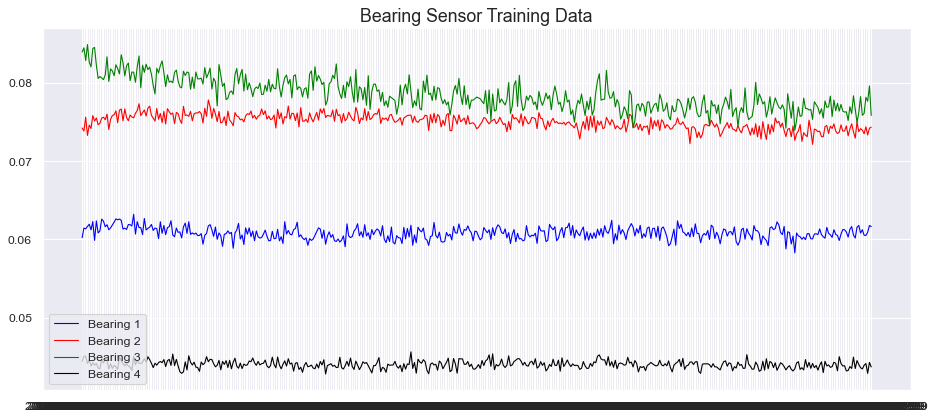

In [8]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

Let’s get a different perspective of the data by transforming the signal from the time domain to the frequency domain using a discrete Fourier transform.

In [9]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

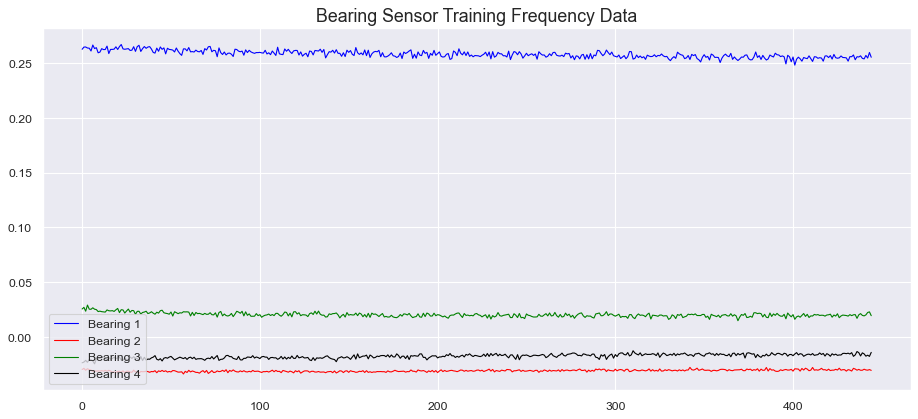

In [10]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

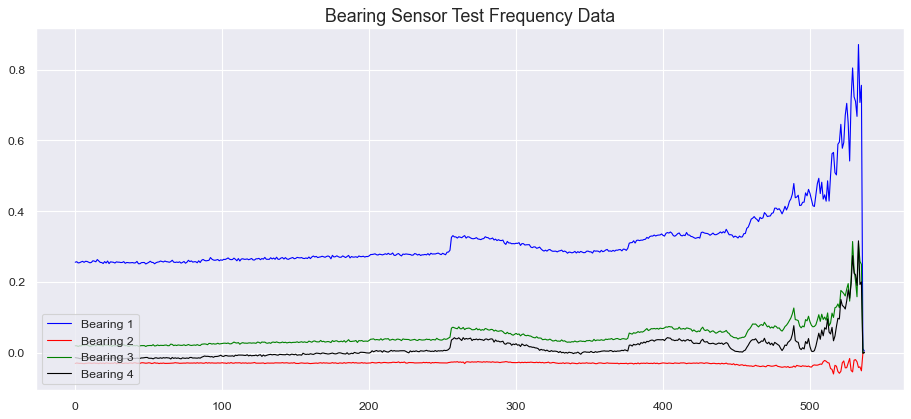

In [11]:
# frequencies of the degrading sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [12]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"

## LSTM Autoencoder

In [13]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


In [14]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [15]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae',metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 4)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 4)              68  

In [16]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Train on 422 samples, validate on 23 samples
Epoch 1/100
422/422 [==============================] - 2s 5ms/step - loss: 0.4472 - accuracy: 0.1754 - val_loss: 0.3244 - val_accuracy: 0.1739
Epoch 2/100
422/422 [==============================] - 1s 1ms/step - loss: 0.3899 - accuracy: 0.1706 - val_loss: 0.2580 - val_accuracy: 0.1739
Epoch 3/100
422/422 [==============================] - 1s 2ms/step - loss: 0.3122 - accuracy: 0.1706 - val_loss: 0.1798 - val_accuracy: 0.1739
Epoch 4/100
422/422 [==============================] - 1s 2ms/step - loss: 0.2061 - accuracy: 0.1706 - val_loss: 0.1587 - val_accuracy: 0.1739
Epoch 5/100
422/422 [==============================] - 1s 2ms/step - loss: 0.1277 - accuracy: 0.2891 - val_loss: 0.1404 - val_accuracy: 0.0000e+00
Epoch 6/100
422/422 [==============================] - 1s 1ms/step - loss: 0.1085 - accuracy: 0.3578 - val_loss: 0.1227 - val_accuracy: 0.2609
Epoch 7/100
422/422 [==============================] - 1s 1ms/step - loss: 0.1040 - accuracy:

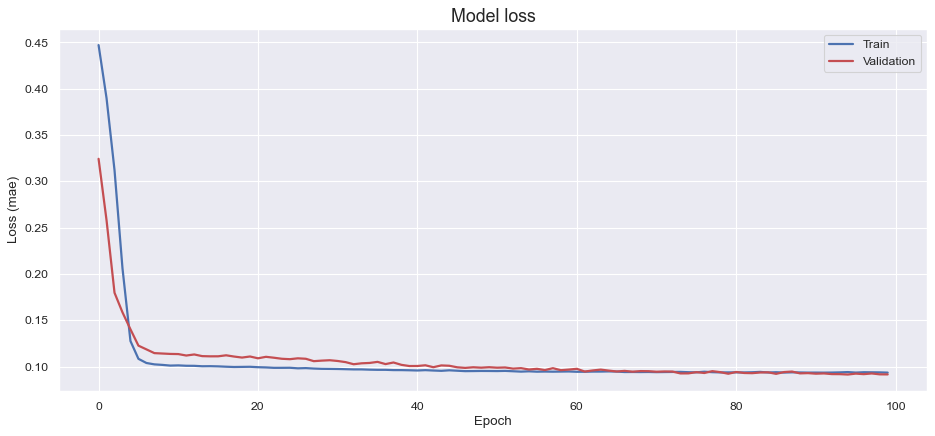

In [17]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.5)

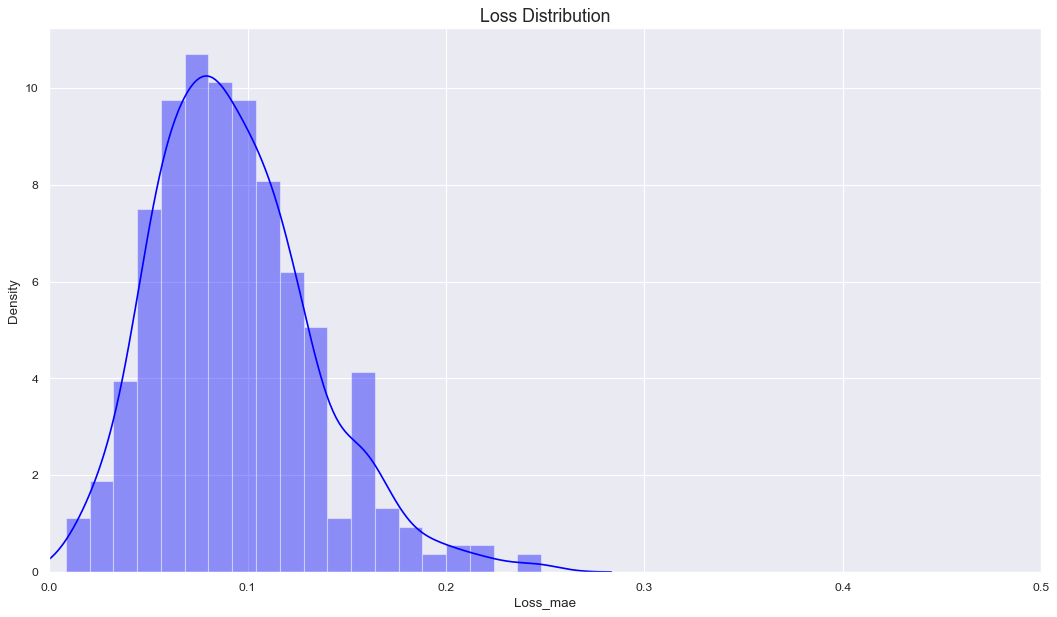

In [18]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [19]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.094051,0.275,False
2004-02-15 13:02:39,0.170021,0.275,False
2004-02-15 13:12:39,0.066047,0.275,False
2004-02-15 13:22:39,0.054870,0.275,False
2004-02-15 13:32:39,0.036208,0.275,False


In [20]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

<AxesSubplot:>

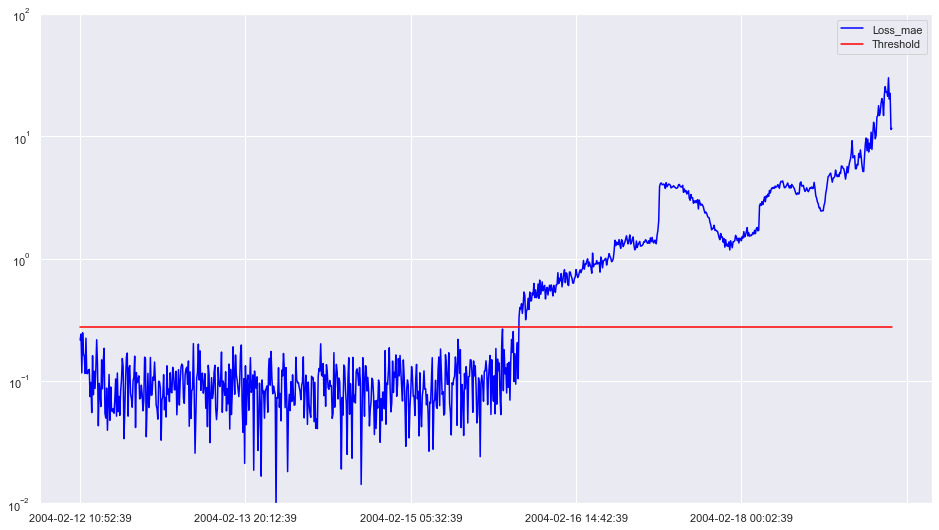

In [21]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

## NN + Autoencoder

In [22]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"

In [23]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1],))
    encode = Dense(4, activation='relu',kernel_regularizer=regularizers.l2(0.01))(inputs)
    encode = BatchNormalization()(encode)
    encode = Dense(2, activation='relu',kernel_regularizer=regularizers.l2(0.01))(encode)
    encode = BatchNormalization()(encode)
    encode = Dense(1, activation='relu',kernel_regularizer=regularizers.l2(0.01))(encode)
    encode = BatchNormalization()(encode)

    decode = Dense(2, activation='relu')(encode)
    decode = BatchNormalization()(decode)
    output = Dense(4, activation='sigmoid')(decode)
    model = Model(inputs=inputs, outputs=output)
    return model

In [24]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae',metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
batch_normalization_1 (Batch (None, 4)                 16        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
_________________________________________________________________
batch_normalization_2 (Batch (None, 2)                 8         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1)                 4   

In [25]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Train on 422 samples, validate on 23 samples
Epoch 1/100
422/422 [==============================] - 1s 3ms/step - loss: 0.2565 - accuracy: 0.3578 - val_loss: 0.2461 - val_accuracy: 0.0000e+00
Epoch 2/100
422/422 [==============================] - 0s 1ms/step - loss: 0.2318 - accuracy: 0.3318 - val_loss: 0.2397 - val_accuracy: 0.0000e+00
Epoch 3/100
422/422 [==============================] - 0s 1ms/step - loss: 0.2104 - accuracy: 0.3934 - val_loss: 0.2297 - val_accuracy: 0.0000e+00
Epoch 4/100
422/422 [==============================] - 0s 1ms/step - loss: 0.2025 - accuracy: 0.3744 - val_loss: 0.2217 - val_accuracy: 0.8261
Epoch 5/100
422/422 [==============================] - 0s 1ms/step - loss: 0.1974 - accuracy: 0.3744 - val_loss: 0.2126 - val_accuracy: 0.8261
Epoch 6/100
422/422 [==============================] - 0s 1ms/step - loss: 0.1914 - accuracy: 0.3673 - val_loss: 0.2075 - val_accuracy: 0.8261
Epoch 7/100
422/422 [==============================] - 1s 1ms/step - loss: 0.1873 - a

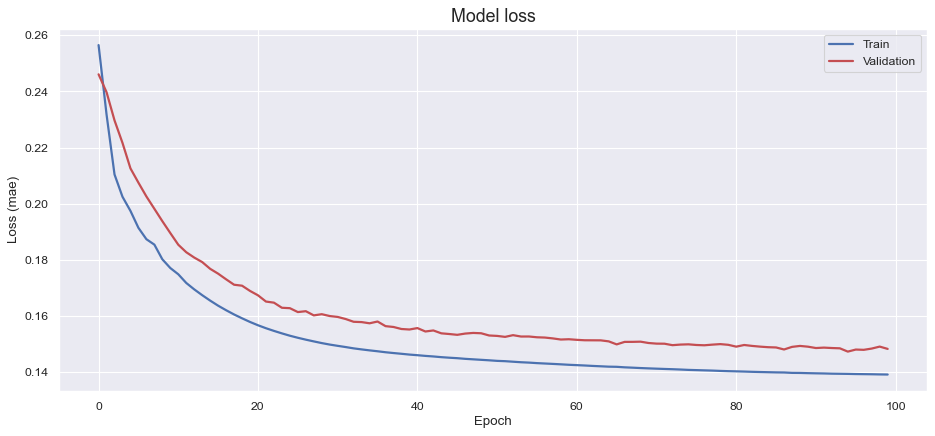

In [26]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.5)

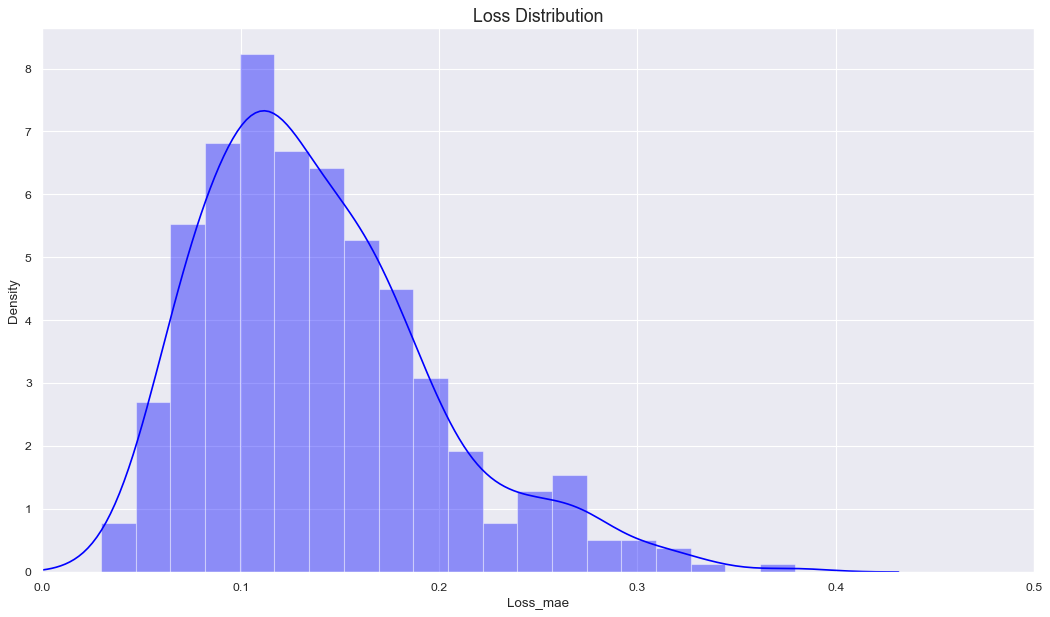

In [27]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [28]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.156755,0.275,False
2004-02-15 13:02:39,0.201042,0.275,False
2004-02-15 13:12:39,0.152448,0.275,False
2004-02-15 13:22:39,0.171333,0.275,False
2004-02-15 13:32:39,0.086220,0.275,False


In [29]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

<AxesSubplot:>

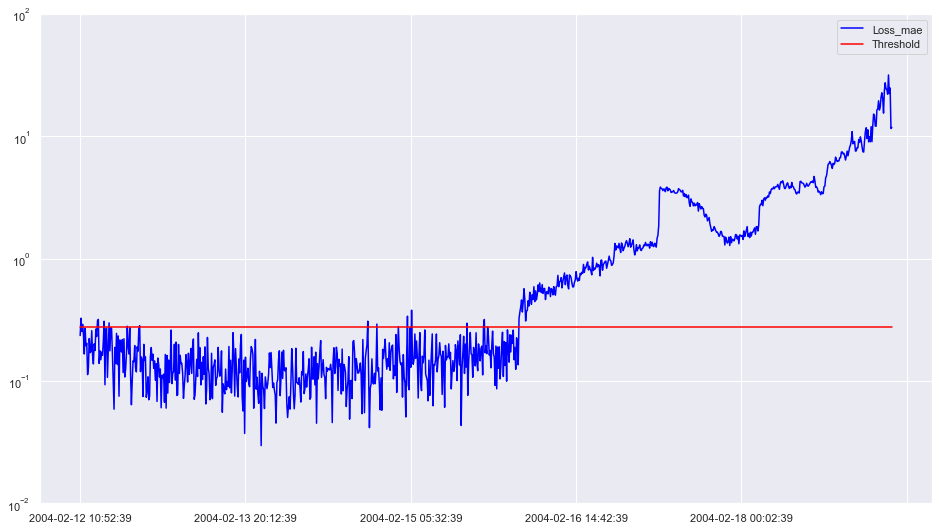

In [30]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

## Isolation Forest

In [31]:
clf = IsolationForest(random_state = 42)
clf.fit(X_train)
pred = clf.predict(X_train)

In [33]:
pca = PCA(n_components=2)
pca.fit(X_train)
printcipalComponents = pca.transform(X_train)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])

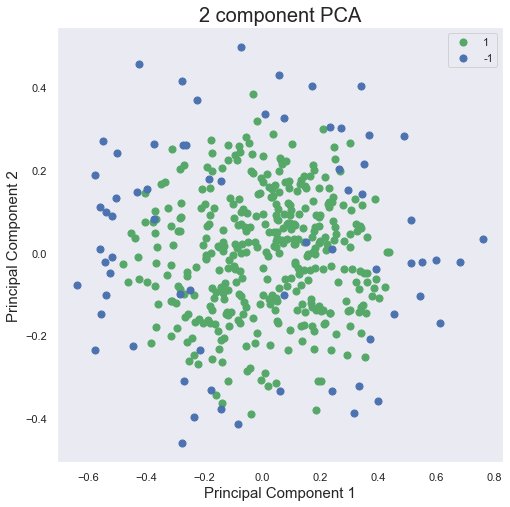

In [34]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)

targets = [1, -1]
colors = ['g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = pred == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component1']
               , principalDf.loc[indicesToKeep, 'principal component2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [35]:
pred = clf.predict(X_test)

In [36]:
pca = PCA(n_components=2)
pca.fit(X_test)
printcipalComponents = pca.transform(X_test)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])

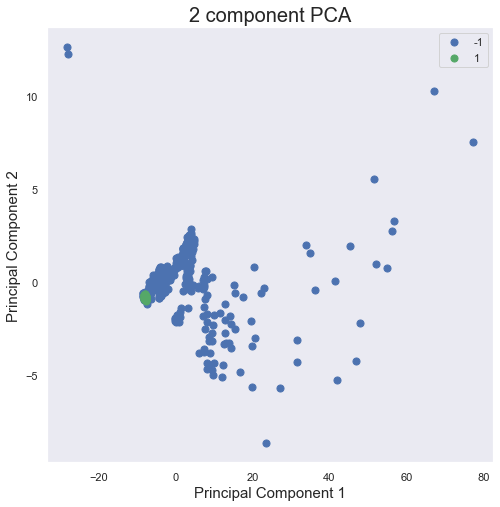

In [37]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)

targets = [-1, 1]
colors = ['b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = pred == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component1']
               , principalDf.loc[indicesToKeep, 'principal component2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## One Class SVM

In [38]:
clf = OneClassSVM(gamma='auto').fit(X_train)
pred = clf.predict(X_train)
pred_score = clf.score_samples(X_train)

In [39]:
pca = PCA(n_components=2)
pca.fit(X_train)
printcipalComponents = pca.transform(X_train)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])

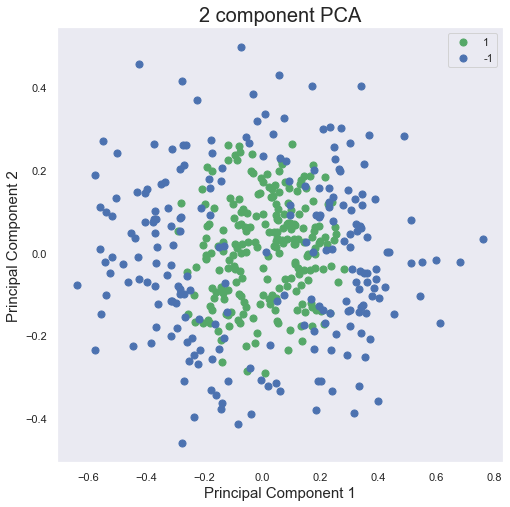

In [40]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)

targets = [1, -1]
colors = ['g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = pred == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component1']
               , principalDf.loc[indicesToKeep, 'principal component2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [41]:
pred = clf.predict(X_test)

In [42]:
pca = PCA(n_components=2)
pca.fit(X_test)
printcipalComponents = pca.transform(X_test)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])

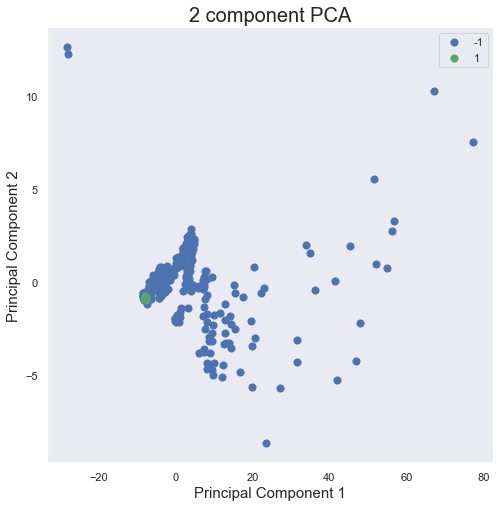

In [43]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)

targets = [-1, 1]
colors = ['b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = pred == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component1']
               , principalDf.loc[indicesToKeep, 'principal component2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [57]:
# define the autoencoder network model
def nn_autoencoder_model(X):
    inputs = Input(shape=(X.shape[1],))
    encode = Dense(4, activation='relu',kernel_regularizer=regularizers.l2(0.01))(inputs)
    encode = BatchNormalization()(encode)
    encode = Dense(2, activation='relu',kernel_regularizer=regularizers.l2(0.01))(encode)
    encode = BatchNormalization()(encode)
    encode = Dense(1, activation='relu',kernel_regularizer=regularizers.l2(0.01))(encode)
    encode = BatchNormalization()(encode)

    decode = Dense(2, activation='relu')(encode)
    decode = BatchNormalization()(decode)
    output = Dense(4, activation='sigmoid')(decode)
    model = Model(inputs=inputs, outputs=output)
    return model

In [58]:
# 1st Autoencoder
autoencoder = nn_autoencoder_model(X_train)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

history1 = autoencoder.fit(X_train, X_train,
        epochs=100,
        batch_size=10,
        shuffle=True)
print('========== First Autoencoder Finish ==========')

# Isolation Forest
f1_pre = autoencoder.predict(X_train)

clf = IsolationForest(random_state = 42, contamination = 0.3)
clf.fit(f1_pre)
pred = clf.predict(f1_pre)

p1 = f1_pre[pred==1]
p2 = f1_pre[pred==-1]

# 2st Autoencoder
autoencoder = nn_autoencoder_model(p1)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

history2 = autoencoder.fit(p1, p1,
        epochs=100,
        batch_size=10,
        shuffle=True)
print('========== Second Autoencoder Finish ==========')

=========] - 1s 1ms/step - loss: 0.0964 - accuracy: 0.4180
Epoch 7/100
445/445 [==============================] - 1s 1ms/step - loss: 0.0889 - accuracy: 0.4157
Epoch 8/100
445/445 [==============================] - 1s 1ms/step - loss: 0.0830 - accuracy: 0.4247
Epoch 9/100
445/445 [==============================] - 1s 1ms/step - loss: 0.0770 - accuracy: 0.4360
Epoch 10/100
445/445 [==============================] - 1s 1ms/step - loss: 0.0732 - accuracy: 0.3955
Epoch 11/100
445/445 [==============================] - 1s 1ms/step - loss: 0.0686 - accuracy: 0.4337
Epoch 12/100
445/445 [==============================] - 1s 1ms/step - loss: 0.0650 - accuracy: 0.4292
Epoch 13/100
445/445 [==============================] - 1s 1ms/step - loss: 0.0618 - accuracy: 0.4337
Epoch 14/100
445/445 [==============================] - 1s 1ms/step - loss: 0.0592 - accuracy: 0.3933
Epoch 15/100
445/445 [==============================] - 1s 1ms/step - loss: 0.0566 - accuracy: 0.3888
Epoch 16/100
445/445 [====

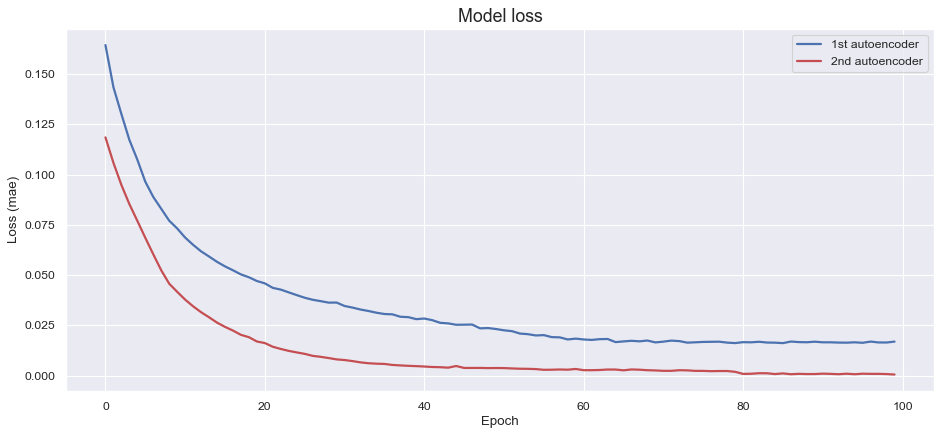

In [59]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history1.history['loss'], 'b', label='1st autoencoder', linewidth=2)
ax.plot(history2.history['loss'], 'r', label='2nd autoencoder', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()